<a href="https://colab.research.google.com/github/thunderhoser/ai2es_xai_course/blob/main/lecture05a_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 5a: Novelty detection and integrated gradients

This notebook was used for the AI2ES (NSF Institute for Research on Trustworthy Artificial Intelligence in Weather, Climate, and Coastal Oceanography) short course on XAI (explainable artificial intelligence) in May-June 2021.

If you use code from this notebook, please cite it as follows.

Lagerquist, Ryan, and David John Gagne II, 2021: "Lecture 5a: Novelty detection and integrated gradients". AI2ES (NSF Institute for Research on Trustworthy Artificial Intelligence in Weather, Climate, and Coastal Oceanography) short course on XAI (explainable artificial intelligence), https://github.com/thunderhoser/ai2es_xai_course/.

# References

This notebook refers to a few publications, listed below.  Schwartz *et al.* (2015) documents the dataset used.

Schwartz, C., G. Romine, M. Weisman, R. Sobash, K. Fossell, K. Manning, and S. Trier, 2015: "A real-time convection-allowing ensemble prediction system initialized by mesoscale ensemble Kalman filter analyses." *Weather and Forecasting*, **30 (5)**, 1158-1181, https://doi.org/10.1175/WAF-D-15-0013.1.

Wagstaff, K., and J. Lee: "Interpretable discovery in large image data sets." *arXiv e-prints*, **1806**, https://arxiv.org/abs/1806.08340.

# <font color='red'>Clone the Git repository (required)</font>

- **Please note**: when a section title is in <font color='red'>red</font>, that means the code cell below is required.
- In other words, if you don't run the code cell below, subsequent code cells might not work.

In [ ]:
import os
import shutil

# !pip install 'keras>=2.4.0,<2.5.0' --force-reinstall

if os.path.isdir('course_repository'):
    shutil.rmtree('course_repository')

!git clone https://github.com/thunderhoser/ai2es_xai_course course_repository
!cd course_repository; python setup.py install

Cloning into 'course_repository'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (237/237), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 237 (delta 145), reused 160 (delta 72), pack-reused 0
Receiving objects: 100% (237/237), 105.36 MiB | 28.21 MiB/s, done.
Resolving deltas: 100% (145/145), done.
running install
running bdist_egg
running egg_info
creating ai2es_xai_course.egg-info
writing ai2es_xai_course.egg-info/PKG-INFO
writing dependency_links to ai2es_xai_course.egg-info/dependency_links.txt
writing requirements to ai2es_xai_course.egg-info/requires.txt
writing top-level names to ai2es_xai_course.egg-info/top_level.txt
writing manifest file 'ai2es_xai_course.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'ai2es_xai_course.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/ai2es_xai_course

# <font color='red'>Import packages (required)</font>

The next two cells import all packages used in the notebook.

In [ ]:
import sys

sys.path.append('/content/data/')
sys.path.append('/content/course_repository/')
sys.path.append('/content/course_repository/ai2es_xai_course/')
sys.path.append('/content/course_repository/ai2es_xai_course/utils/')

In [ ]:
%matplotlib inline
import copy
import random
import os.path
import warnings
import numpy
import keras
import tensorflow
from matplotlib import pyplot
from ai2es_xai_course.plotting import image_plotting
from ai2es_xai_course.utils import utils, image_utils, image_normalization, \
    image_thresholding, cnn, saliency, novelty_detection
from ai2es_xai_course.utils import integrated_gradients as integ_grad

warnings.filterwarnings('ignore')
tensorflow.compat.v1.enable_eager_execution()
tensorflow.compat.v1.experimental.output_all_intermediates(True)

SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

TABULAR_DATA_DIR_NAME = '/content/data/track_data_ncar_ams_3km_csv_small'
IMAGE_DATA_DIR_NAME = '/content/data/track_data_ncar_ams_3km_nc_small'

BEST_HIT_MATRIX_KEY = 'best_hits_predictor_matrix'
WORST_FALSE_ALARM_MATRIX_KEY = 'worst_false_alarms_predictor_matrix'
WORST_MISS_MATRIX_KEY = 'worst_misses_predictor_matrix'
BEST_CORRECT_NULLS_MATRIX_KEY = 'best_correct_nulls_predictor_matrix'
PREDICTOR_NAMES_KEY = 'predictor_names'

# <font color='red'>Prevent auto-scrolling (required)</font>

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# <font color='red'>Download input data (required)</font>

The next cell downloads all input data used in this notebook.

In [ ]:
!python /content/course_repository/download_image_data.py

Unzipping file: "data/track_data_ncar_ams_3km_nc_small.tar.gz"...


# <font color='red'>Read input data (required)</font>

The next cell reads all input data for this notebook into memory.

In [ ]:
image_training_file_names = image_utils.find_many_files(
    first_date_string='20100101', last_date_string='20141224',
    directory_name=IMAGE_DATA_DIR_NAME
)

image_validation_file_names = image_utils.find_many_files(
    first_date_string='20150101', last_date_string='20151231',
    directory_name=IMAGE_DATA_DIR_NAME
)

image_testing_file_names = image_utils.find_many_files(
    first_date_string='20160101', last_date_string='20171231',
    directory_name=IMAGE_DATA_DIR_NAME
)

training_image_dict = image_utils.read_many_files(image_training_file_names)
print('\n')

validation_image_dict = image_utils.read_many_files(image_validation_file_names)
print('\n')

testing_image_dict = image_utils.read_many_files(image_testing_file_names)

Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110414-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110420-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARS

# <font color='red'>Normalization (required)</font>

The next cell does the following:

 - Finds normalization parameters (mean and standard deviation) for each channel, based only on the training data.
 - But does not actually normalize any data (this will be done on the fly, as needed).  Keeping a normalized and unnormalized version of each dataset (training, validation, and testing) would take up too much memory.

In [ ]:
image_normalization_dict = image_normalization.get_normalization_params(
    image_dict=training_image_dict
)

# <font color='red'>Binarization of target variable (required)</font>

The next cell does the following:

 - Finds the binarization threshold (on max future vorticity in s$^{-1}$) for image data.
 - Does not actually binarize image data (this will be done on the fly, as needed).

In [ ]:
image_binarization_threshold = image_thresholding.get_binarization_threshold(
    image_dict=training_image_dict, percentile_level=90.
)


Binarization threshold for "max_future_vorticity_s01" = 5.4310e-03


# <font color='red'>Read pre-trained CNN (required)</font>

The next cell reads a pre-trained CNN, which will be used for all explanation methods in this notebook.

In [ ]:
cnn_file_name = '/content/course_repository/pretrained_cnn/model.h5'
cnn_model_object = utils.read_dense_net(cnn_file_name)
cnn_model_object.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        1184      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)       

# <font color='red'>Read pre-trained upconvnet (required)</font>

The next cell reads a pre-trained upconvolutional network (upconvnet), which will be used for novelty detection.

In [ ]:
nd_cnn_file_name = (
    '/content/course_repository/pretrained_upconvnet/pretrained_cnn.h5'
)
nd_cnn_model_object = utils.read_dense_net(nd_cnn_file_name)

upconvnet_file_name = (
    '/content/course_repository/pretrained_upconvnet/pretrained_ucn.h5'
)
upconvnet_model_object = utils.read_dense_net(upconvnet_file_name)
upconvnet_model_object.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6400)]            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 10, 10, 256)       590080    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10, 10, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 256)       1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 12, 12, 128)       295040    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12, 12, 128)       0   

In [ ]:
from ai2es_xai_course.utils import upconvnet

upconvnet_model_object = upconvnet.setup_upconvnet()

del training_image_dict
del validation_image_dict
del testing_image_dict

upconvnet.train_model_sans_generator(
    model_object=upconvnet_model_object, cnn_model_object=cnn_model_object,
    training_file_names=image_training_file_names,
    validation_file_names=image_validation_file_names,
    num_examples_per_batch=512, normalization_dict=image_normalization_dict,
    num_epochs=100, output_dir_name='./data'
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4096)]            0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 256)         590080    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 256)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 256)         1024      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         295040

In [ ]:
from google.colab import files

files.download('./data/model_epoch=098_val-loss=-0.086199.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Extreme cases for pre-trained CNN

There are four types of extreme cases, defined below.  A positive (negative) example is a storm that does (not) develop strong rotation in the future.

 - **Best hits**: the 100 positive examples with highest forecast probability
 - **Worst false alarms**: the 100 negative examples with highest forecast probability
 - **Worst misses**: the 100 positive examples with lowest forecast probability
 - **Best correct nulls**: the 100 negative examples with lowest forecast probability

## <font color='red'>Find extreme cases (required)</font>

The next cell finds extreme cases for the pre-trained CNN.

In [ ]:
predictor_names = testing_image_dict[image_utils.PREDICTOR_NAMES_KEY]

testing_predictor_matrix_denorm = (
    testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY]
)

testing_predictor_matrix_norm, _ = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(testing_predictor_matrix_denorm),
    predictor_names=predictor_names, normalization_dict=image_normalization_dict
)

testing_classes = image_thresholding.binarize_target_images(
    target_matrix=testing_image_dict[image_utils.TARGET_MATRIX_KEY],
    binarization_threshold=image_binarization_threshold
)

testing_probs = cnn.apply_model(
    model_object=cnn_model_object,
    predictor_matrix=testing_predictor_matrix_norm
)

this_dict = utils.find_extreme_examples(
    observed_labels=testing_classes, forecast_probabilities=testing_probs,
    num_examples_per_set=100
)
best_hit_indices = this_dict[utils.HIT_INDICES_KEY]
worst_false_alarm_indices = this_dict[utils.FALSE_ALARM_INDICES_KEY]
worst_miss_indices = this_dict[utils.MISS_INDICES_KEY]
best_correct_null_indices = this_dict[utils.CORRECT_NULL_INDICES_KEY]

extreme_example_dict_denorm = {
    BEST_HIT_MATRIX_KEY:
        testing_predictor_matrix_denorm[best_hit_indices, ...],
    WORST_FALSE_ALARM_MATRIX_KEY:
        testing_predictor_matrix_denorm[worst_false_alarm_indices, ...],
    WORST_MISS_MATRIX_KEY:
        testing_predictor_matrix_denorm[worst_miss_indices, ...],
    BEST_CORRECT_NULLS_MATRIX_KEY:
        testing_predictor_matrix_denorm[best_correct_null_indices, ...],
    PREDICTOR_NAMES_KEY: predictor_names
}

extreme_example_dict_norm = {
    BEST_HIT_MATRIX_KEY:
        testing_predictor_matrix_norm[best_hit_indices, ...],
    WORST_FALSE_ALARM_MATRIX_KEY:
        testing_predictor_matrix_norm[worst_false_alarm_indices, ...],
    WORST_MISS_MATRIX_KEY:
        testing_predictor_matrix_norm[worst_miss_indices, ...],
    BEST_CORRECT_NULLS_MATRIX_KEY:
        testing_predictor_matrix_norm[best_correct_null_indices, ...],
    PREDICTOR_NAMES_KEY: predictor_names
}

this_bh_matrix = utils.run_pmm_many_variables(
    field_matrix=extreme_example_dict_denorm[BEST_HIT_MATRIX_KEY]
)
this_wfa_matrix = utils.run_pmm_many_variables(
    field_matrix=extreme_example_dict_denorm[WORST_FALSE_ALARM_MATRIX_KEY]
)
this_wm_matrix = utils.run_pmm_many_variables(
    field_matrix=extreme_example_dict_denorm[WORST_MISS_MATRIX_KEY]
)
this_bcn_matrix = utils.run_pmm_many_variables(
    field_matrix=extreme_example_dict_denorm[BEST_CORRECT_NULLS_MATRIX_KEY]
)

extreme_example_dict_denorm_pmm = {
    BEST_HIT_MATRIX_KEY: this_bh_matrix,
    WORST_FALSE_ALARM_MATRIX_KEY: this_wfa_matrix,
    WORST_MISS_MATRIX_KEY: this_wm_matrix,
    BEST_CORRECT_NULLS_MATRIX_KEY: this_bcn_matrix,
    PREDICTOR_NAMES_KEY: predictor_names
}

Applying model to examples 0-999 of 19368...
Applying model to examples 1000-1999 of 19368...
Applying model to examples 2000-2999 of 19368...
Applying model to examples 3000-3999 of 19368...
Applying model to examples 4000-4999 of 19368...
Applying model to examples 5000-5999 of 19368...
Applying model to examples 6000-6999 of 19368...
Applying model to examples 7000-7999 of 19368...
Applying model to examples 8000-8999 of 19368...
Applying model to examples 9000-9999 of 19368...
Applying model to examples 10000-10999 of 19368...
Applying model to examples 11000-11999 of 19368...
Applying model to examples 12000-12999 of 19368...
Applying model to examples 13000-13999 of 19368...
Applying model to examples 14000-14999 of 19368...
Applying model to examples 15000-15999 of 19368...
Applying model to examples 16000-16999 of 19368...
Applying model to examples 17000-17999 of 19368...
Applying model to examples 18000-18999 of 19368...
Applying model to examples 19000-19367 of 19368...
Have

## Plot extreme cases

 - The next cell plots a composite (average storm) for each set of extreme cases.
 - Specifically, we plot the PMM (probability-matched means; Ebert 2001) composite.
 - PMM is similar to taking the arithmetic mean at each grid cell, but it preserves spatial structure better.

In [ ]:
best_hits_matrix_denorm_pmm = extreme_example_dict_denorm_pmm[
    BEST_HIT_MATRIX_KEY
]
worst_fa_matrix_denorm_pmm = extreme_example_dict_denorm_pmm[
    WORST_FALSE_ALARM_MATRIX_KEY
]
worst_misses_matrix_denorm_pmm = extreme_example_dict_denorm_pmm[
    WORST_MISS_MATRIX_KEY
]
best_nulls_matrix_denorm_pmm = extreme_example_dict_denorm_pmm[
    BEST_CORRECT_NULLS_MATRIX_KEY
]
predictor_names = extreme_example_dict_denorm_pmm[PREDICTOR_NAMES_KEY]

concat_predictor_matrix = numpy.stack((
    best_hits_matrix_denorm_pmm, worst_fa_matrix_denorm_pmm,
    worst_misses_matrix_denorm_pmm, best_nulls_matrix_denorm_pmm,
), axis=0)

temperature_matrix_kelvins = concat_predictor_matrix[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_with_barbs(
        predictor_matrix=best_hits_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins)
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Best hits')

pyplot.show()
print('\n\n')

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_with_barbs(
        predictor_matrix=worst_fa_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins)
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Worst false alarms')

pyplot.show()
print('\n\n')

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_with_barbs(
        predictor_matrix=worst_misses_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins)
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Worst misses')

pyplot.show()
print('\n\n')

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_with_barbs(
        predictor_matrix=best_nulls_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins)
)

for i in range(axes_object_matrix.shape[0]):
    for j in range(axes_object_matrix.shape[1]):
        axes_object_matrix[i, j].set_title('Best correct nulls')

# Novelty detection

## Theory

Add stuff here.

## Run novelty detection

The next cell runs novelty detection with the following settings, then finds the 4 most novel examples from the trial set.

 - Baseline set = 100 negative validation examples (weak future rotation)
 - Trial set = 100 validation examples with strongest future rotation

In [ ]:
target_matrix_s_01 = validation_image_dict[image_utils.TARGET_MATRIX_KEY]
max_target_values_s01 = numpy.max(target_matrix_s_01, axis=(1, 2))

trial_indices = numpy.argsort(-1 * max_target_values_s01)[:100]
trial_indices = trial_indices[trial_indices >= 100]
baseline_indices = numpy.linspace(0, 100, num=100, dtype=int)

baseline_predictor_matrix_denorm = (
    validation_image_dict[image_utils.PREDICTOR_MATRIX_KEY][baseline_indices, ...]
    + 0.
)
trial_predictor_matrix_denorm = (
    validation_image_dict[image_utils.PREDICTOR_MATRIX_KEY][trial_indices, ...]
    + 0.
)
predictor_names = validation_image_dict[image_utils.PREDICTOR_NAMES_KEY]

baseline_predictor_matrix_norm, _ = image_normalization.normalize_data(
    predictor_matrix=baseline_predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=image_normalization_dict
)
trial_predictor_matrix_norm, _ = image_normalization.normalize_data(
    predictor_matrix=trial_predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=image_normalization_dict
)

novelty_dict = novelty_detection.run_novelty_detection(
    baseline_predictor_matrix_norm=baseline_predictor_matrix_norm,
    trial_predictor_matrix_norm=trial_predictor_matrix_norm,
    cnn_model_object=cnn_model_object,
    cnn_feature_layer_name=cnn.get_flattening_layer(cnn_model_object),
    upconvnet_model_object=upconvnet_model_object,
    num_novel_examples=4, multipass=False
)

novelty_dict[novelty_detection.NOVEL_MATRIX_KEY] = (
    image_normalization.denormalize_data(
        predictor_matrix=novelty_dict[novelty_detection.NOVEL_MATRIX_KEY],
        predictor_names=predictor_names,
        normalization_dict=image_normalization_dict
    )
)

novelty_dict[novelty_detection.NOVEL_MATRIX_UPCONV_KEY] = (
    image_normalization.denormalize_data(
        predictor_matrix=
        novelty_dict[novelty_detection.NOVEL_MATRIX_UPCONV_KEY],
        predictor_names=predictor_names,
        normalization_dict=image_normalization_dict
    )
)

novelty_dict[novelty_detection.NOVEL_MATRIX_UPCONV_SVD_KEY] = (
    image_normalization.denormalize_data(
        predictor_matrix=
        novelty_dict[novelty_detection.NOVEL_MATRIX_UPCONV_SVD_KEY],
        predictor_names=predictor_names,
        normalization_dict=image_normalization_dict
    )
)

Applying model to examples 0-99 of 100...
Have applied model to all 100 examples!


Applying model to examples 0-99 of 100...
Have applied model to all 100 examples!


Finding 1th-most novel trial example...
[9.94883716e-01 4.18987777e-03 4.75200184e-04 2.99269217e-04
 5.33049642e-05 4.18899472e-05 2.36033029e-05 1.23029968e-05
 7.31463888e-06 5.66146309e-06 2.36315054e-06 1.62575918e-06
 1.15736282e-06 9.85921588e-07 6.68226619e-07 5.03347280e-07
 2.62621882e-07 1.20958617e-07 8.45531005e-08 5.82317199e-08
 3.63564290e-08 2.49609435e-08 1.78328712e-08 1.36452636e-08
 1.02628963e-08 8.09882472e-09 5.28041566e-09 2.41140752e-09
 1.76178727e-09 1.11918697e-09 5.78989134e-10 3.02177172e-10
 1.90171490e-10 1.46476553e-10 1.18950461e-10 6.88436530e-11
 5.76327874e-11 3.89280275e-11 2.86454888e-11 2.82810442e-11
 1.29019920e-11 1.05129100e-11 6.56151479e-12 4.55882294e-12
 4.12499765e-12 2.55790311e-12 2.06963483e-12 1.71854956e-12
 1.39164244e-12 1.04006528e-12 7.93478727e-13 6.11313842e-13

## Plot most novel example

The next cell plots the most novel trial example.

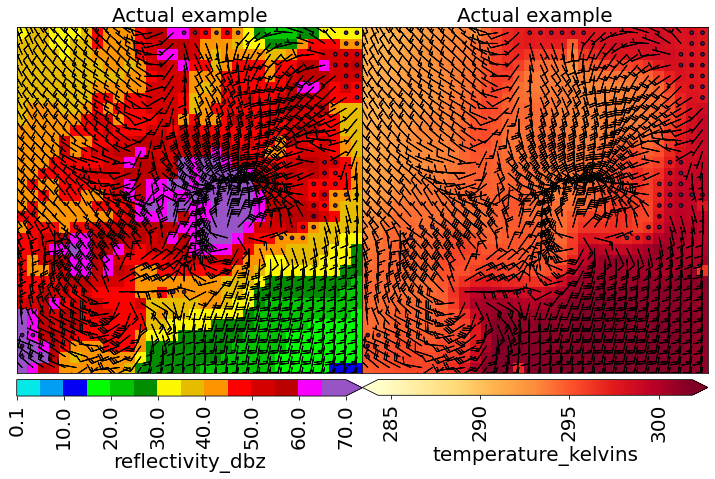

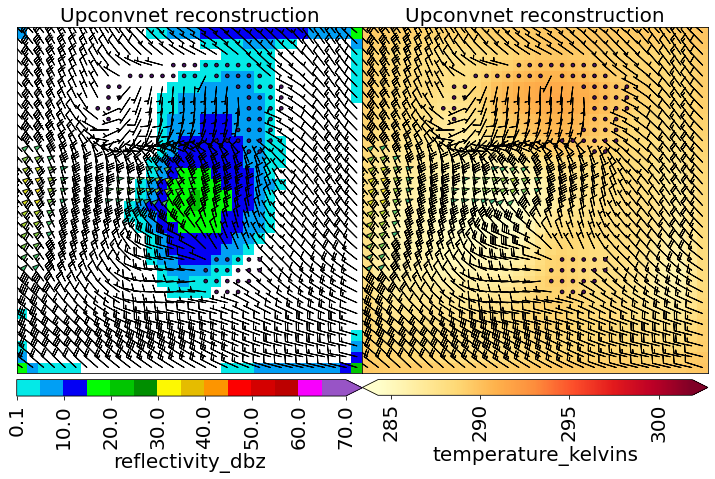

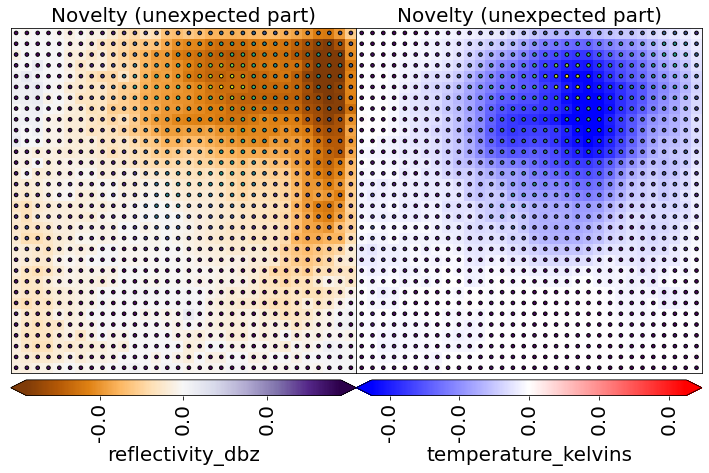

In [ ]:
novelty_detection.plot_results(
    novelty_dict_denorm=novelty_dict, plot_index=0,
    predictor_names=validation_image_dict[image_utils.PREDICTOR_NAMES_KEY]
)

## Plot 2$^{\textrm{nd}}$-most novel example

The next cell plots the second-most novel example.

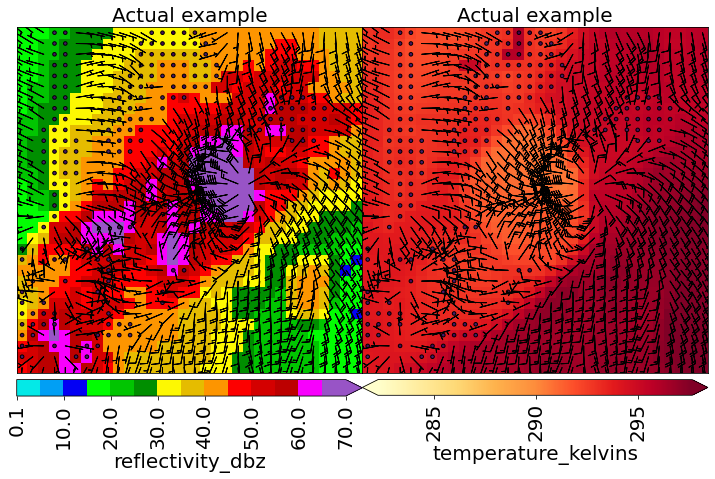

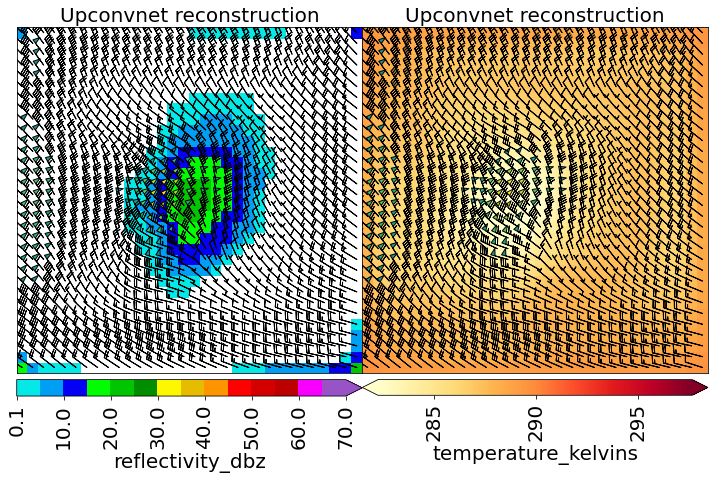

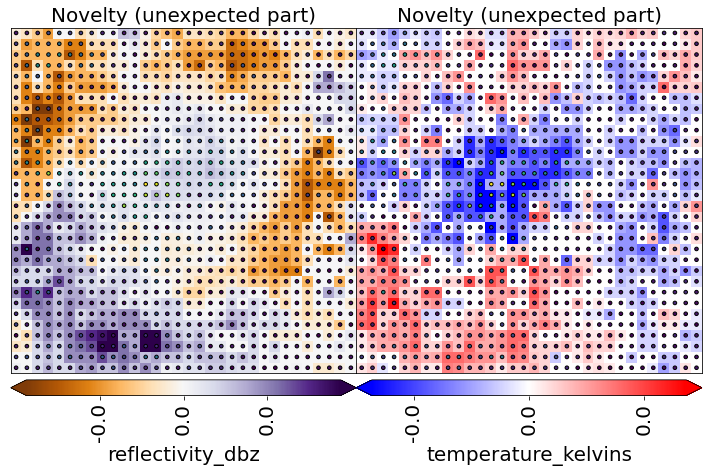

In [ ]:
novelty_detection.plot_results(
    novelty_dict_denorm=novelty_dict, plot_index=1,
    predictor_names=validation_image_dict[image_utils.PREDICTOR_NAMES_KEY]
)

## Plot 3$^{\textrm{rd}}$-most novel example

The next cell plots the third-most novel example.

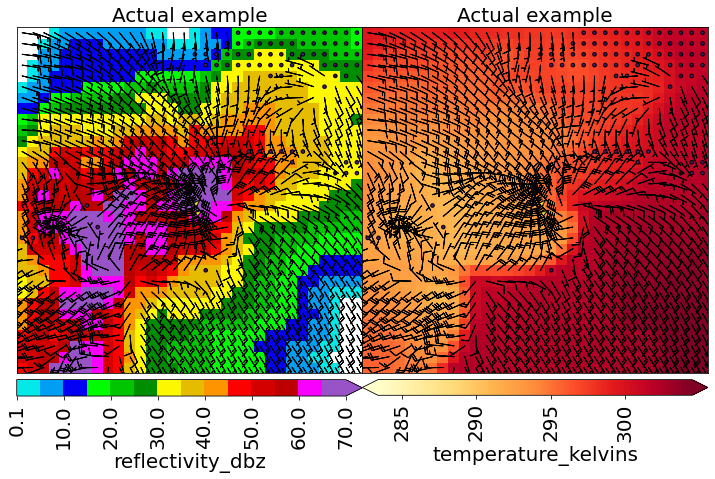

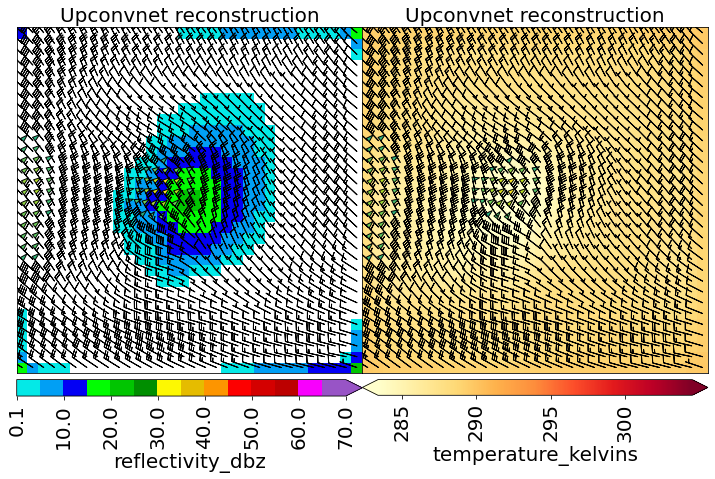

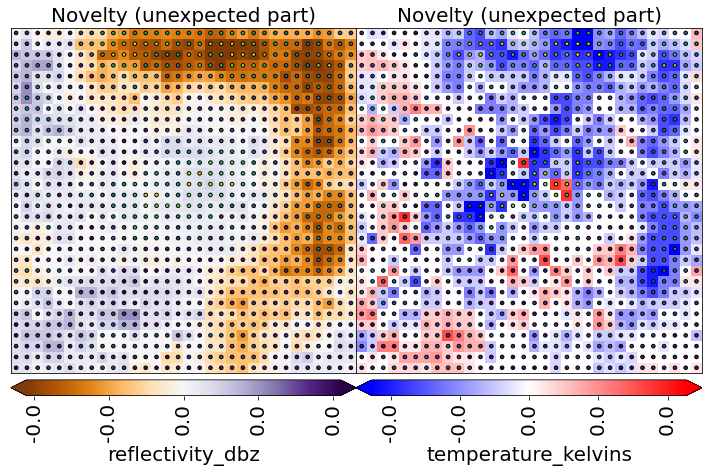

In [ ]:
novelty_detection.plot_results(
    novelty_dict_denorm=novelty_dict, plot_index=2,
    predictor_names=validation_image_dict[image_utils.PREDICTOR_NAMES_KEY]
)

## Plot 4$^{\textrm{th}}$-most novel example

The next cell plots the fourth-most novel example.

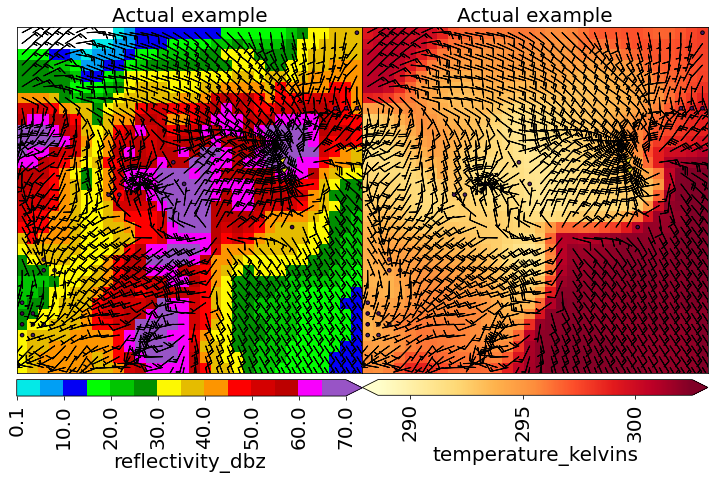

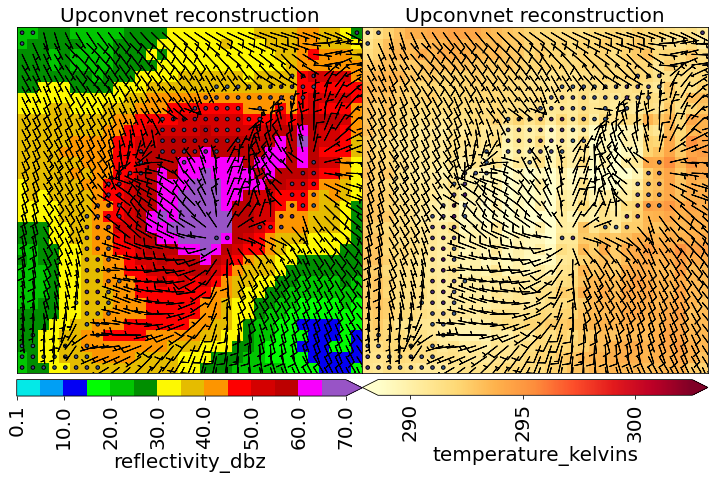

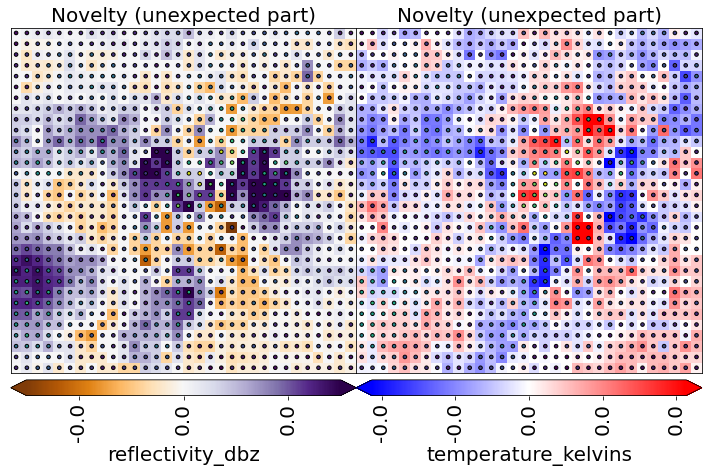

In [ ]:
novelty_detection.plot_results(
    novelty_dict_denorm=novelty_dict, plot_index=3,
    predictor_names=validation_image_dict[image_utils.PREDICTOR_NAMES_KEY]
)

# Integrated gradients

## Theory

Add stuff here.

## Integrated gradients for random example

The next cell computes and plots the integrated-gradient map for a random example in the testing data.  To interpret the plot:

 - Solid contours mean positive contribution from predictor (causing probability of strong rotation, $p$, to increase).
 - Dashed contours mean negative contribution from predictor (causing $p$ to decrease).
 - Positive $u$-wind is westerly (towards the east/right).
 - Positive $v$-wind is southerly (towards the north/top).

Have run integrated-gradients method for 0 of 1 examples...
[[[ 2.59945020e-07  1.59370799e-07 -6.23891766e-07 -5.12071779e-08]
  [ 4.80798302e-07  8.55518650e-07 -2.00869440e-06 -7.65430238e-08]
  [ 2.45535131e-07  2.16929899e-06 -4.80918257e-07 -3.93059462e-08]
  ...
  [ 1.48693182e-06  2.24651282e-06  4.88578132e-07  2.66895529e-07]
  [ 1.52947149e-06  2.17771235e-06  2.76508329e-07  5.09169056e-07]
  [-1.64343250e-07  1.57977520e-06 -3.31581948e-07  3.82629596e-07]]

 [[-2.47790392e-06  1.17693416e-06  9.55066461e-07 -7.09920443e-08]
  [-2.32461934e-06 -5.00080298e-07 -5.93677174e-07 -6.97571432e-08]
  [-1.09840374e-06  7.15478686e-07  1.15012512e-06 -1.19458721e-07]
  ...
  [ 1.77009538e-06  1.20659182e-06  1.96592228e-06 -3.57966060e-08]
  [ 1.57029091e-06  4.97585248e-07 -1.15138609e-07 -3.82232780e-08]
  [-5.41693343e-07  6.77037053e-07 -6.75401714e-07  1.95291506e-08]]

 [[-1.79762989e-06 -1.14821772e-06  7.40177822e-07 -2.18123602e-08]
  [-1.10154384e-06 -9.85703521e-07 -9.96

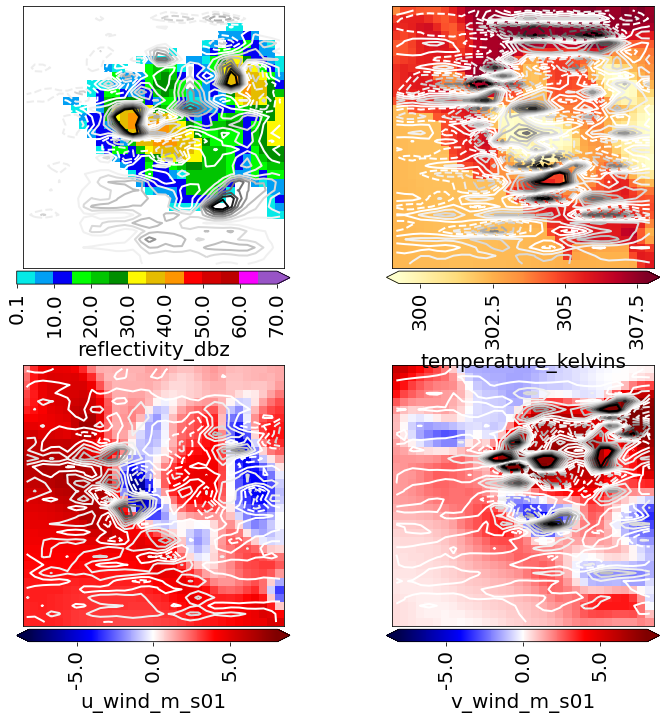

In [ ]:
predictor_matrix_denorm = testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY]
predictor_names = testing_image_dict[image_utils.PREDICTOR_NAMES_KEY]

num_examples = predictor_matrix_denorm.shape[0]
random_index = random.randint(0, num_examples - 1)
# random_index = 14138
predictor_matrix_denorm = predictor_matrix_denorm[random_index, ...]

predictor_matrix_norm, _ = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(predictor_matrix_denorm),
    predictor_names=predictor_names, normalization_dict=image_normalization_dict
)

integ_grad_matrix = integ_grad.run_integrated_gradients(
    model_object=cnn_model_object,
    predictor_matrix=numpy.expand_dims(predictor_matrix_norm, axis=0),
    target_class=1, num_interp_steps=50
)[0, ...]

integ_grad_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[integ_grad_matrix], smoothing_radius_grid_cells=1
)[0]

temperature_matrix_kelvins = predictor_matrix_denorm[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(image_utils.U_WIND_NAME),
    predictor_names.index(image_utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(predictor_matrix_denorm[..., wind_indices]), 99
)

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=predictor_matrix_denorm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

max_colour_value = numpy.percentile(numpy.absolute(integ_grad_matrix), 99)

saliency.plot_saliency_maps(
    saliency_matrix_3d=integ_grad_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_colour_value,
    contour_interval=max_colour_value / 8
)

## Integrated gradients for strong example

The next cell computes and plots the integrated-gradient map for the strongest example in the testing data (that with the greatest max future vorticity).

Have run integrated-gradients method for 0 of 1 examples...
[[[-8.62071509e-06  3.51493426e-05 -1.63920584e-05  9.86184485e-06]
  [ 2.04883175e-06  8.78072446e-05 -4.85643265e-05  1.11214528e-04]
  [-1.26798707e-05  3.64345656e-05 -3.46134372e-05  1.33479597e-04]
  ...
  [ 1.25973333e-05  7.79900792e-06  3.33009718e-06  1.84875967e-05]
  [-8.52487382e-07  2.36545146e-06 -8.28095764e-07 -2.67393064e-05]
  [ 4.74260846e-07 -1.77319189e-07  2.92852103e-06 -7.06781860e-06]]

 [[-7.58578040e-05 -7.38586068e-06  1.14921523e-04  1.01588379e-04]
  [-6.25193155e-05 -1.04890241e-04  8.77359811e-05  1.38809569e-04]
  [-7.71903500e-05 -1.06547819e-04 -1.47570679e-04 -5.23779837e-05]
  ...
  [ 2.80636456e-05  3.43722044e-05  1.67284657e-05  1.31485677e-04]
  [ 4.98100876e-06  3.83944072e-05 -4.78967231e-06  6.73450141e-05]
  [ 3.20311417e-06  1.91867738e-05  4.14425605e-06  1.37138341e-05]]

 [[-3.11423212e-05 -7.06864300e-05  8.63370411e-05  2.35283030e-05]
  [-1.38853947e-05 -3.35145706e-05  9.74

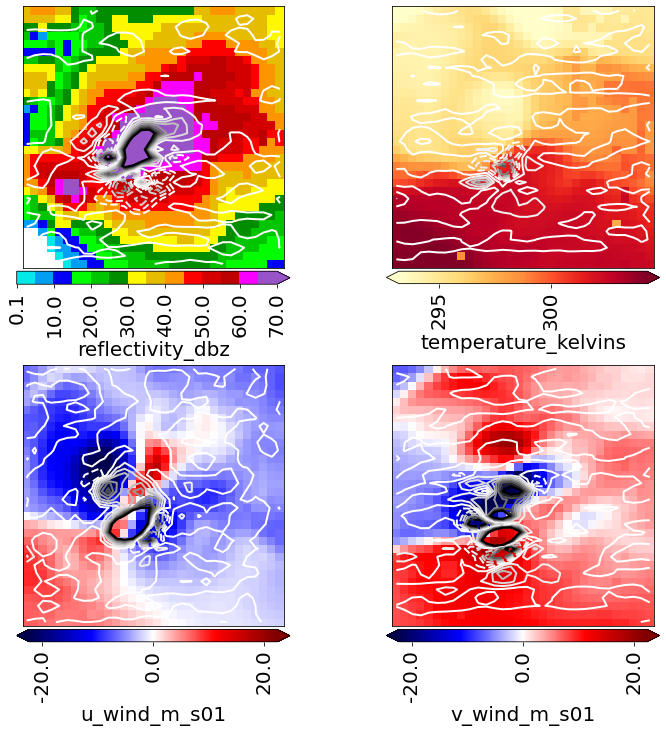

In [ ]:
target_matrix_s01 = testing_image_dict[image_utils.TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

predictor_matrix_denorm = (
    testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY][example_index, ...]
)
predictor_names = testing_image_dict[image_utils.PREDICTOR_NAMES_KEY]

predictor_matrix_norm, _ = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(predictor_matrix_denorm),
    predictor_names=predictor_names, normalization_dict=image_normalization_dict
)

integ_grad_matrix = integ_grad.run_integrated_gradients(
    model_object=cnn_model_object,
    predictor_matrix=numpy.expand_dims(predictor_matrix_norm, axis=0),
    target_class=1, num_interp_steps=50
)[0, ...]

integ_grad_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[integ_grad_matrix], smoothing_radius_grid_cells=1
)[0]

temperature_matrix_kelvins = predictor_matrix_denorm[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(image_utils.U_WIND_NAME),
    predictor_names.index(image_utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(predictor_matrix_denorm[..., wind_indices]), 99
)

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=predictor_matrix_denorm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

max_colour_value = numpy.percentile(numpy.absolute(integ_grad_matrix), 99)

saliency.plot_saliency_maps(
    saliency_matrix_3d=integ_grad_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_colour_value,
    contour_interval=max_colour_value / 8
)

## Integrated gradients for extreme cases

The next two cells compute, then plot, the composite (PMM) integrated-gradient map for each set of extreme cases.

In [ ]:
bh_integ_grad_matrix = integ_grad.run_integrated_gradients(
    model_object=cnn_model_object,
    predictor_matrix=extreme_example_dict_norm[BEST_HIT_MATRIX_KEY],
    target_class=1, num_interp_steps=50
)
bh_integ_grad_matrix = utils.run_pmm_many_variables(
    field_matrix=bh_integ_grad_matrix
)
bh_integ_grad_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[bh_integ_grad_matrix],
    smoothing_radius_grid_cells=1
)[0]

wfa_integ_grad_matrix = integ_grad.run_integrated_gradients(
    model_object=cnn_model_object,
    predictor_matrix=extreme_example_dict_norm[WORST_FALSE_ALARM_MATRIX_KEY],
    target_class=1, num_interp_steps=50
)
wfa_integ_grad_matrix = utils.run_pmm_many_variables(
    field_matrix=wfa_integ_grad_matrix
)
wfa_integ_grad_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[wfa_integ_grad_matrix],
    smoothing_radius_grid_cells=1
)[0]

wm_integ_grad_matrix = integ_grad.run_integrated_gradients(
    model_object=cnn_model_object,
    predictor_matrix=extreme_example_dict_norm[WORST_MISS_MATRIX_KEY],
    target_class=1, num_interp_steps=50
)
wm_integ_grad_matrix = utils.run_pmm_many_variables(
    field_matrix=wm_integ_grad_matrix
)
wm_integ_grad_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[wm_integ_grad_matrix],
    smoothing_radius_grid_cells=1
)[0]

bcn_integ_grad_matrix = integ_grad.run_integrated_gradients(
    model_object=cnn_model_object,
    predictor_matrix=extreme_example_dict_norm[BEST_CORRECT_NULLS_MATRIX_KEY],
    target_class=1, num_interp_steps=50
)
bcn_integ_grad_matrix = utils.run_pmm_many_variables(
    field_matrix=bcn_integ_grad_matrix
)
bcn_integ_grad_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[bcn_integ_grad_matrix],
    smoothing_radius_grid_cells=1
)[0]

Streaming output truncated to the last 5000 lines.
  [-6.44296670e-07  2.75534103e-07  4.56604186e-07 -1.08094818e-06]
  [ 1.11875841e-06  2.33192467e-07  3.14574367e-07  3.90786034e-08]
  [ 1.98620839e-07  3.50793399e-07 -5.78631541e-07  5.40330468e-07]]

 ...

 [[-7.16334302e-07 -7.47624980e-07 -1.52511475e-07 -2.29682357e-07]
  [-1.45044231e-06 -2.71970605e-06  1.80832650e-07 -4.16145730e-07]
  [-1.11678666e-06 -2.25862226e-06 -2.53965885e-07 -8.70935446e-07]
  ...
  [-1.45395439e-06 -1.46049921e-06  6.77453376e-08 -9.07700604e-07]
  [-7.44988322e-07 -2.88354753e-07 -3.66839904e-07 -6.04243954e-08]
  [-9.72997585e-07 -1.56547193e-07 -9.54989221e-08 -5.59468170e-07]]

 [[-6.27677673e-07 -5.07715891e-07 -2.55222299e-07  8.79810135e-08]
  [-1.90920780e-06  7.27835088e-07  2.61701331e-08 -6.58901545e-08]
  [-3.01675579e-06 -9.33083294e-07  2.78301320e-08  3.31869111e-07]
  ...
  [-4.09803209e-06  1.00239185e-07  4.09791816e-07  5.65933074e-07]
  [-2.82754675e-06  1.17624697e-06 -2.75324

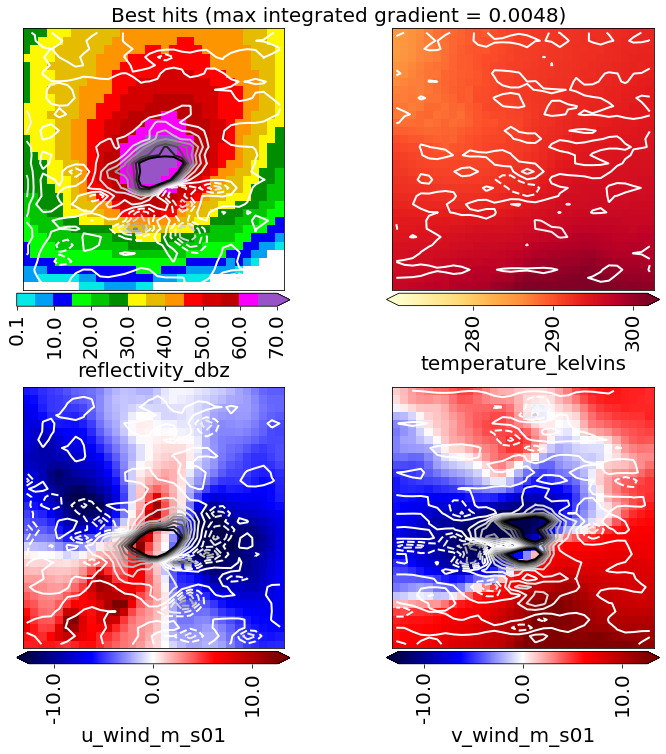

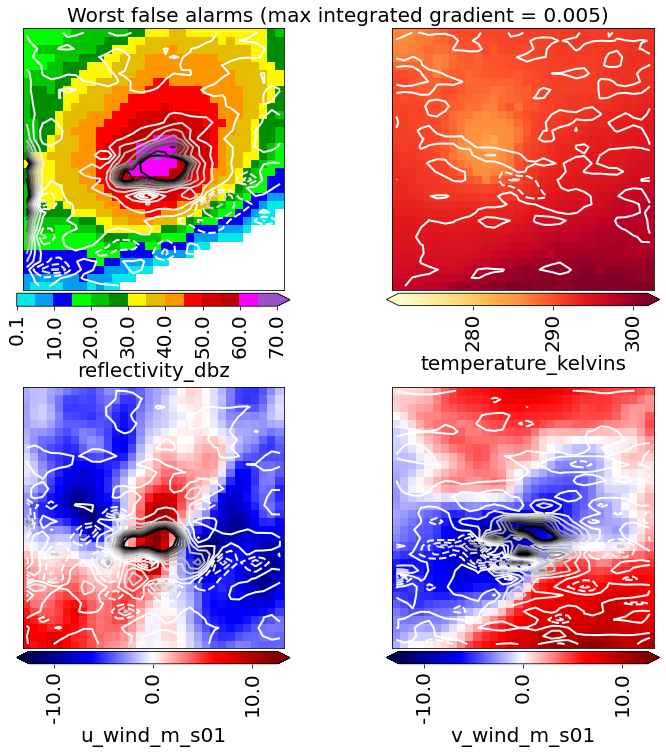

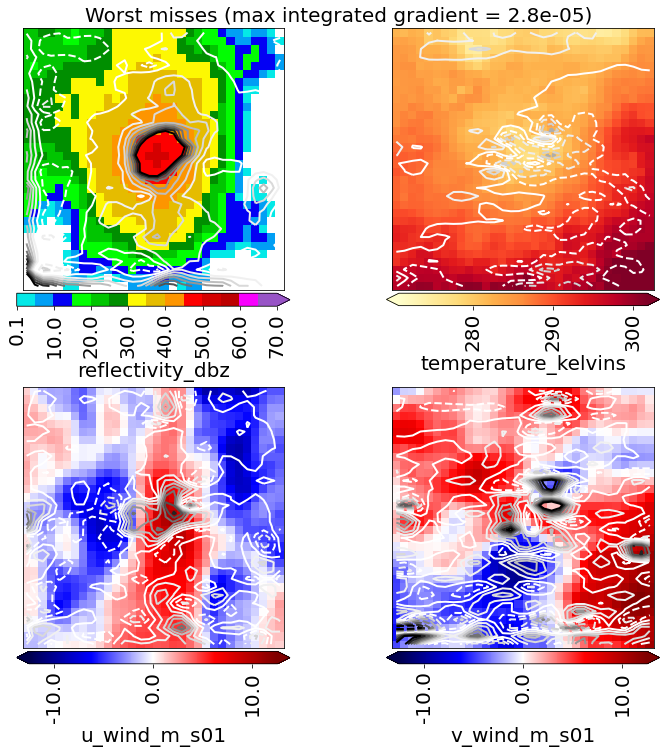

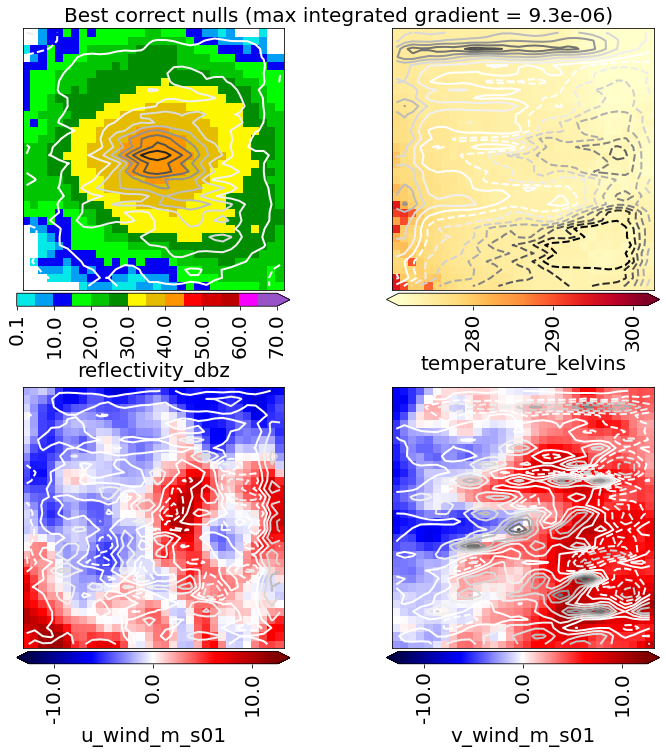

In [ ]:
predictor_names = extreme_example_dict_denorm_pmm[PREDICTOR_NAMES_KEY]

concat_predictor_matrix = numpy.stack((
    extreme_example_dict_denorm_pmm[BEST_HIT_MATRIX_KEY],
    extreme_example_dict_denorm_pmm[WORST_FALSE_ALARM_MATRIX_KEY],
    extreme_example_dict_denorm_pmm[WORST_MISS_MATRIX_KEY],
    extreme_example_dict_denorm_pmm[BEST_CORRECT_NULLS_MATRIX_KEY]
), axis=0)

temperature_matrix_kelvins = concat_predictor_matrix[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(image_utils.U_WIND_NAME),
    predictor_names.index(image_utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(concat_predictor_matrix[..., wind_indices]), 99
)

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=extreme_example_dict_denorm_pmm[BEST_HIT_MATRIX_KEY],
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

max_colour_value = numpy.percentile(numpy.absolute(bh_integ_grad_matrix), 99)
saliency.plot_saliency_maps(
    saliency_matrix_3d=bh_integ_grad_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_colour_value,
    contour_interval=max_colour_value / 8
)

figure_object.suptitle(
    'Best hits (max integrated gradient = {0:.2g})'.format(max_colour_value)
)
pyplot.show()
print('\n\n')

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=
        extreme_example_dict_denorm_pmm[WORST_FALSE_ALARM_MATRIX_KEY],
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

max_colour_value = numpy.percentile(numpy.absolute(wfa_integ_grad_matrix), 99)
saliency.plot_saliency_maps(
    saliency_matrix_3d=wfa_integ_grad_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_colour_value,
    contour_interval=max_colour_value / 8
)

figure_object.suptitle(
    'Worst false alarms (max integrated gradient = {0:.2g})'.format(
        max_colour_value
    )
)
pyplot.show()
print('\n\n')

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=
        extreme_example_dict_denorm_pmm[WORST_MISS_MATRIX_KEY],
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

max_colour_value = numpy.percentile(numpy.absolute(wm_integ_grad_matrix), 99)
saliency.plot_saliency_maps(
    saliency_matrix_3d=wm_integ_grad_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_colour_value,
    contour_interval=max_colour_value / 8
)

figure_object.suptitle(
    'Worst misses (max integrated gradient = {0:.2g})'.format(max_colour_value)
)
pyplot.show()
print('\n\n')

figure_object, axes_object_matrix = (
    image_plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=
        extreme_example_dict_denorm_pmm[BEST_CORRECT_NULLS_MATRIX_KEY],
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01
    )
)

max_colour_value = numpy.percentile(numpy.absolute(bcn_integ_grad_matrix), 99)
saliency.plot_saliency_maps(
    saliency_matrix_3d=bcn_integ_grad_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_colour_value,
    contour_interval=max_colour_value / 8
)

figure_object.suptitle(
    'Best correct nulls (max integrated gradient = {0:.2g})'.format(
        max_colour_value
    )
)
pyplot.show()